In [1]:
from osgeo import ogr, gdal, osr
import pandas as pd
import shapely.wkt
import fiona
import numpy as np
import boto3
from datacube import Datacube
from datacube.utils.geometry import CRS, Geometry, GeoBox
from datacube.testutils.io import native_geobox, native_load
from datacube.utils.dask import start_local_dask
import rioxarray as rioxr
import awswrangler as wr
from datetime import timedelta, datetime
import dask.dataframe as dd

In [3]:
golden_wo = rioxr.open_rasterio("ga_ls_wo_fq_cyear_3_x49y24_2015--P1Y_final_count_clear-2.tif")

In [4]:
new_wo = rioxr.open_rasterio("ga_ls_wo_fq_cyear_3_x49y24_2015--P1Y_final_count_clear.tif")

In [9]:
(golden_wo == new_wo).all()

<xarray.DataArray ()>
array(True)
Coordinates:
    spatial_ref  int64 0

In [13]:
!gdalcompare.py -sds -skip_binary "ga_ls_wo_fq_cyear_3_x49y24_2015--P1Y_final_count_clear-2.tif" "ga_ls_wo_fq_cyear_3_x49y24_2015--P1Y_final_count_clear.tif"

Unrecognised argument: ga_ls_wo_fq_cyear_3_x49y24_2015--P1Y_final_count_clear.tif
Usage: gdalcompare.py [-sds] <golden_file> <new_file>


In [16]:
!gdalcompare.py --version

GDAL 3.7.0, released 2023/05/02


In [12]:
def locate_landsat_scene(landsat_shape, grid_shape, grid_id):
    ds_landsat = ogr.Open(landsat_shape)
    lyr_landsat = ds_landsat.GetLayer(0)
    lyr_landsat.ResetReading()
    ds_grid = ogr.Open(grid_shape)
    lyr_grid = ds_grid.GetLayer(0)
    lyr_grid.ResetReading()
    for grid in lyr_grid:
        if grid['region_code'] == grid_id:
            break
    lyr_landsat.SetSpatialFilter(grid.geometry())
    query_poly = {}
    for l in lyr_landsat:
        query_poly[l['PR']] = Geometry(shapely.wkt.loads(l.geometry().ExportToWkt()), crs=CRS('EPSG:4326'))
    return query_poly

In [14]:
def poly_from_region_code(region_code, grids_file):
    with fiona.open(grids_file) as allshapes:
        for shape in allshapes:
            if shape['properties'].get('region_code', '') == region_code.lower():
                return Geometry(shape['geometry'], crs=CRS('EPSG:4326'))

In [28]:
def landsat_scene_poly(landsat_shape, region_code):
    with fiona.open(landsat_shape) as all_shapes:
        for s in all_shapes:
            if s['properties'].get('PR') == region_code:
                if len(str(region_code)) < 6:
                    rc = '0' + str(region_code)
                else:
                    rc = str(region_code)
                return {rc: Geometry(dict(s['geometry']), crs=CRS('EPSG:4326'))}

In [244]:
def native_load_dss(dss, measurements, base_ds):
    geobox = native_geobox(
            base_ds, basis=list(dss[0].measurements.keys())[0]
        )
    mm = dss[0].type.lookup_measurements(measurements)
    tmp_data = Datacube.load_data(Datacube.group_datasets(dss, 'time'),
                    geobox, measurements=mm, dask_chunks={'time': 1, 'x': -1, 'y': -1})
        
    return tmp_data

In [41]:
landsat_shape = "./landsat_au/landsat_au.shp"
grid_shape = "./au-grid.geojson"
au_shape = "./aus_map/cstauscd_r.shp"
dc= Datacube()

In [14]:
grids = pd.read_csv("grid_test_fc_percentile_mangroves.csv")

In [21]:
scene_set = []
for grid in grids["New grid"]:
    scenes = locate_landsat_scene(landsat_shape, grid_shape, str(grid).lower())
    scene_set += list(scenes.keys())

{112082: Geometry(POLYGON ((115.458618977745 -32.3156878698949, 115.867 -30.8496, 115.867258836738 -30.8496375984429, 117.775887039436 -31.1268835914278, 117.776 -31.1269, 117.770465870143 -31.1483582337667, 117.756719414509 -31.2016592343069, 117.386 -32.6391, 117.385278343291 -32.6389951569392, 115.447 -32.3574, 115.458618977745 -32.3156878698949)), EPSG:4326), 112083: Geometry(POLYGON ((117.025733175112 -34.0007612174705, 117.013832389581 -34.0458350698364, 117.006 -34.0755, 117.005824391936 -34.0754744748462, 115.037096088205 -33.7893139667061, 115.037 -33.7893, 115.458618977745 -32.3156878698949, 115.468 -32.2829, 117.405 -32.5643, 117.385278343291 -32.6389951569392, 117.025733175112 -34.0007612174705)), EPSG:4326), 113082: Geometry(POLYGON ((116.229970190804 -31.1267504106391, 116.231 -31.1269, 115.859364437159 -32.5642076678455, 115.84 -32.6391, 113.902 -32.3574, 113.913618977745 -32.3156878698949, 114.322 -30.8496, 114.322258836738 -30.8496375984429, 116.229970190804 -31.126750

In [588]:
ls9_underfly_ls8_pr = (["1130" + str(i) for i in range(72, 84)] + 
                       ["0910" +  str(i) for i in range(72, 91)] + 
                       ["0920" +  str(i) for i in range(72, 91)] +
["0940" +  str(i) for i in range(71, 88)])

In [589]:
pr_list = []
for sample_pr in ls9_underfly_ls8_pr:
    query_poly_dict = landsat_scene_poly(landsat_shape, int(sample_pr))
    for region_code, query_poly in query_poly_dict.items():
        pr_list += [(region_code, ) + query_poly.geom.bounds]
np.savetxt("ls9_underfly_ls8.txt", np.array(pr_list), fmt="%s")

In [34]:
pr_list = []
for sample_pr in set(scene_set):
    query_poly_dict = landsat_scene_poly(landsat_shape, int(sample_pr))
    for region_code, query_poly in query_poly_dict.items():
        pr_list += [(region_code, ) + query_poly.geom.bounds]
np.savetxt("validation_tiles_scenes.txt", np.array(pr_list), fmt="%s")

In [587]:
ls9_polygons = np.genfromtxt("ls9_underfly_ls8.txt", dtype=str)

In [590]:
s3_obj =boto3.client('s3')
re_list = {}
for a in ls9_polygons:
    print(a)
    ls9_datasets = wr.s3.list_objects("s3://dea-public-data-dev/test/ls9_wo/ga_ls_wo_3/1-6-0/"+
                                      a[0][:3]+"/"+a[0][3:], suffix=[".json"])
    for d in ls9_datasets:

        s3_clientobj = s3_obj.get_object(Bucket='dea-public-data-dev',
                                     Key=d.removeprefix("s3://dea-public-data-dev/"))
        s3_clientdata = s3_clientobj['Body'].read().decode('utf-8')
        load_path = json.loads(s3_clientdata)["assets"]['water']['href']
        ls9_time = json.loads(s3_clientdata)["properties"]["datetime"]
        ls9_time = datetime.fromisoformat(ls9_time.rstrip('Z') + "+00:00")
        query_poly = Geometry(json.loads(s3_clientdata)["geometry"], crs="4326")
        ls8_query = {}
        ls8_query["geopolygon"] = query_poly
        if ls9_time > datetime.fromisoformat('2021-12-01T23:59:59+00:00'):
            continue
        ls9_crs = json.loads(s3_clientdata)["properties"]["proj:epsg"]
        ls8_query['time'] = (ls9_time-timedelta(days=1),
                         ls9_time+timedelta(days=1))
        ls8_datasets = dc.find_datasets(product='ga_ls_wo_3', platform="landsat-8", **ls8_query)
        ls8_datasets.sort(key=lambda x: x.center_time)
        if ls8_datasets == []:
            continue
        else:
            diff_count = 0
            total_count = 0
            ls9_data = rioxr.open_rasterio(load_path,
                           chunks={'x':-1, 'y':-1})
            non_matching = [ds for ds in ls8_datasets if ds.crs != CRS(str(ls9_crs))]
            print(non_matching)
            ls8_datasets = [ds for ds in ls8_datasets if ds.crs == CRS(str(ls9_crs))]
            print(ls8_datasets)
            for ds in ls8_datasets:
                ls8_data = native_load_dss([ds], measurements=["water"])
                ls_diff = (ls8_data.water.where(ls8_data.water != 1) -  ls9_data[0].where(ls9_data[0] != 1))[0].data
                tmp_count = (np.count_nonzero(ls_diff) - np.isnan(ls_diff).sum())
                tmp_total =  (~np.isnan(ls_diff)).sum()
                print(tmp_count)
                total_count += tmp_total
                diff_count += (np.count_nonzero(ls_diff) - np.isnan(ls_diff).sum())
        re_list[a[0]] = (diff_count, total_count)

['113072' '117.556' '-18.2303' '119.62' '-16.4619']
[Dataset <id=1808c512-2c9d-524a-9fe2-e930993a45fe product=ga_ls_wo_3 location=s3://dea-public-data/derivative/ga_ls_wo_3/1-6-0/112/072/2021/11/13/ga_ls_wo_3_112072_2021-11-13_final.stac-item.json>]
[Dataset <id=74824227-b8dd-5a06-a21a-5a65deb60261 product=ga_ls_wo_3 location=s3://dea-public-data/derivative/ga_ls_wo_3/1-6-0/112/073/2021/11/13/ga_ls_wo_3_112073_2021-11-13_final.stac-item.json>]
dask.array<sub, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>
['113073' '117.218' '-19.674' '119.3' '-17.9043']
[]
[Dataset <id=74824227-b8dd-5a06-a21a-5a65deb60261 product=ga_ls_wo_3 location=s3://dea-public-data/derivative/ga_ls_wo_3/1-6-0/112/073/2021/11/13/ga_ls_wo_3_112073_2021-11-13_final.stac-item.json>, Dataset <id=0fa9e9ef-e8b7-5bdd-9a42-18c9637fd437 product=ga_ls_wo_3 location=s3://dea-public-data/derivative/ga_ls_wo_3/1-6-0/112/074/2021/11/13/ga_ls_wo_3_112074_2021-11-13_final.stac-item.json>]
dask.array<sub, shape=(), 

In [660]:
client.close()

In [661]:
client = start_local_dask(n_workers=1, threads_per_worker=60, memory_limit='400GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 60,Total memory: 372.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38511,Workers: 1
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,Total threads: 60
Started: Just now,Total memory: 372.53 GiB
Comm: tcp://127.0.0.1:38175,Total threads: 60
Dashboard: /user/emma.ai@ga.gov.au/proxy/42879/status,Memory: 372.53 GiB
Nanny: tcp://127.0.0.1:35907,


In [593]:
re_dd = dd.from_dask_array(dask.array.vstack(re_list.values()).transpose(), re_list.keys())

In [594]:
re_dd

,113072,113073,113074,113078,113079,113080,113081,113082,113083,091072,091073,091074,091075,091076,091077,091078,091079,091080,091081,091082,091083,091084,091085,094071,094072,094076,094077,094078,094079,094080,094081,094082,094083
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
1,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [595]:
re_unpacked = re_dd.compute()

In [596]:
re_unpacked.iloc[0] / re_unpacked.iloc[1] 

113072    0.986496
113073    0.969769
113074    0.303309
113078    0.000222
113079    0.000373
113080    0.001945
113081    0.002913
113082    0.020151
113083    0.141502
091072    0.742131
091073    0.539431
091074    0.307390
091075    0.280763
091076    0.326057
091077    0.176921
091078    0.024350
091079    0.021499
091080    0.035786
091081    0.000666
091082    0.002492
091083    0.016267
091084    0.038348
091085    0.139951
094071    0.205775
094072    0.242794
094076    0.000449
094077    0.000834
094078    0.000454
094079    0.000255
094080    0.000447
094081    0.001723
094082    0.088016
094083    0.057882
dtype: float64

In [605]:
    a = ['091077']
    print(a)
    ls9_datasets = wr.s3.list_objects("s3://dea-public-data-dev/test/ls9_wo/ga_ls_wo_3/1-6-0/"+
                                      a[0][:3]+"/"+a[0][3:], suffix=[".json"])
    for d in ls9_datasets:

        s3_clientobj = s3_obj.get_object(Bucket='dea-public-data-dev',
                                     Key=d.removeprefix("s3://dea-public-data-dev/"))
        s3_clientdata = s3_clientobj['Body'].read().decode('utf-8')
        load_path = json.loads(s3_clientdata)["assets"]['water']['href']
        ls9_time = json.loads(s3_clientdata)["properties"]["datetime"]
        ls9_time = datetime.fromisoformat(ls9_time.rstrip('Z') + "+00:00")
        query_poly = Geometry(json.loads(s3_clientdata)["geometry"], crs="4326")
        ls8_query = {}
        ls8_query["geopolygon"] = query_poly
        if ls9_time > datetime.fromisoformat('2021-12-01T23:59:59+00:00'):
            continue
        ls9_crs = json.loads(s3_clientdata)["properties"]["proj:epsg"]
        ls8_query['time'] = (ls9_time-timedelta(days=1),
                         ls9_time+timedelta(days=1))
        ls8_datasets = dc.find_datasets(product='ga_ls_wo_3', platform="landsat-8", **ls8_query)
        ls8_datasets.sort(key=lambda x: x.center_time)
        if ls8_datasets != []:
            break

['091077']


In [607]:
            ls9_data = rioxr.open_rasterio(load_path,
                           chunks={'x':-1, 'y':-1})

In [693]:
ls8_data = native_load_dss(ls8_datasets[1:2], measurements=["water"])

In [694]:
intersect_region = ls8_data.water - ls9_data[0]

In [700]:
                ls_diff = (ls8_data.water.where(ls8_data.water != 1) -  ls9_data[0].where(ls9_data[0] != 1))[0].data
                tmp_count = (np.count_nonzero(ls_diff) - np.isnan(ls_diff).sum())
                tmp_total =  (~np.isnan(ls_diff)).sum()

In [701]:
tmp_count / tmp_total

0.16307558437413713

In [691]:
tmp_total

6855208

In [698]:
ls8_data.load()

<xarray.Dataset>
Dimensions:      (time: 1, y: 7861, x: 7771)
Coordinates:
  * time         (time) datetime64[ns] 2021-11-17T00:00:11.997352
  * y            (y) float64 -2.6e+06 -2.6e+06 ... -2.836e+06 -2.836e+06
  * x            (x) float64 6.249e+05 6.249e+05 6.25e+05 ... 8.58e+05 8.58e+05
    spatial_ref  int32 32655
Data variables:
    water        (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    crs:           epsg:32655
    grid_mapping:  spatial_ref

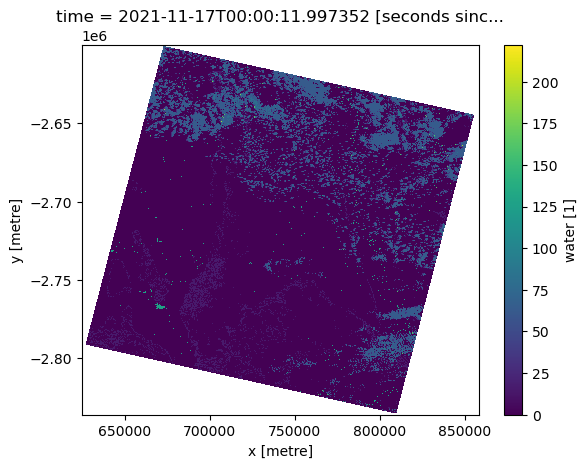

In [702]:
ls8_data.water.where(ls8_data.water != 1)[0].plot.imshow()

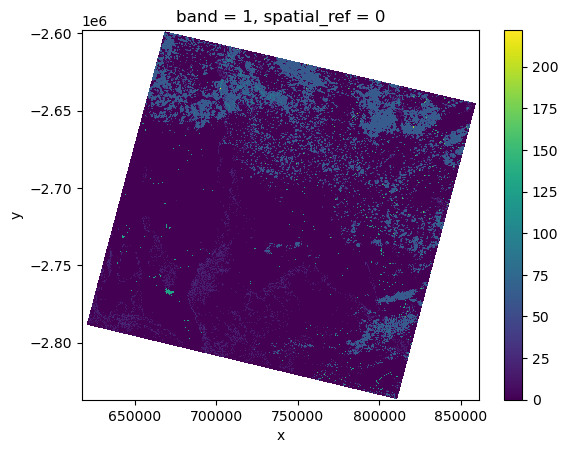

In [619]:
ls9_data[0].where(ls9_data[0] != 1).plot.imshow()

In [621]:
import matplotlib.pyplot as plt

In [703]:
ls9_data.load()

<xarray.DataArray (band: 1, y: 7961, x: 8121)>
array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.174e+05 6.174e+05 6.175e+05 ... 8.61e+05 8.61e+05
  * y            (y) float64 -2.598e+06 -2.598e+06 ... -2.837e+06 -2.837e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     1
    scale_factor:   1.0
    add_offset:     0.0

In [684]:
(ls9_data[0].sel(x=intersect_region.x, y=intersect_region.y) == 1).sum()

<xarray.DataArray ()>
array(5466349)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

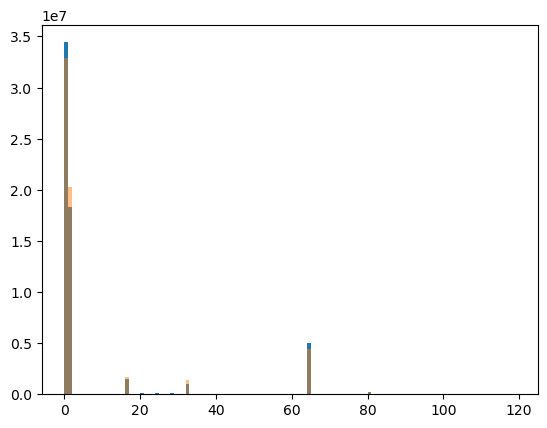

In [704]:
ls9_num, bins, _ = plt.hist(ls9_data[0].sel(x=intersect_region.x, y=intersect_region.y).data.reshape(-1),
         bins=np.arange(0, 120))
ls8_num, _, _ = plt.hist(ls8_data.water[0].sel(x=intersect_region.x, y=intersect_region.y).data.reshape(-1),
         bins=np.arange(0, 120), alpha=0.5)

In [705]:
ls9_num

array([3.4430263e+07, 1.8270448e+07, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       5.6724000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.5038120e+06, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       8.6935000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       8.5139000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       7.8711000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.0408660e+06, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.5730000e+03, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       4.1838000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       2.4280000e+03, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.9710000e+03, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [706]:
ls9_num - ls8_num

array([ 1.535443e+06, -1.967263e+06,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        5.672400e+04,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
       -1.578490e+05,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        8.685600e+04,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        8.512400e+04,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        7.870800e+04,  0.000000e+00,  0.000000e+00,  0.000000e+00,
       -3.401090e+05,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        1.573000e+03,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
       -1.460700e+04,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        2.423000e+03,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        1.949000e+03,  0.000000e+00,  0.000000e+00,  0.000000e

In [707]:
[bin(a) for a in np.where((ls9_num - ls8_num) != 0)[0]]

['0b0',
 '0b1',
 '0b1000',
 '0b10000',
 '0b10100',
 '0b11000',
 '0b11100',
 '0b100000',
 '0b101000',
 '0b110000',
 '0b110100',
 '0b111000',
 '0b111100',
 '0b1000000',
 '0b1001000',
 '0b1010000',
 '0b1010100',
 '0b1011000',
 '0b1011100']

In [456]:
np.array_equal(((ls8_data.water.where(ls8_data.water != 1) -  ls9_data[0].where(ls9_data[0] != 1))[0]).data, 0, equal_nan=True)

/env/lib/python3.10/site-packages/dask/array/core.py:1712: FutureWarning: The `numpy.array_equal` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


False

In [282]:
ls8_data.y

<xarray.DataArray 'y' (y: 7691)>
array([-1804800., -1804830., -1804860., ..., -2035440., -2035470., -2035500.])
Coordinates:
  * y            (y) float64 -1.805e+06 -1.805e+06 ... -2.035e+06 -2.036e+06
    spatial_ref  int32 32651
Attributes:
    units:       metre
    resolution:  -30.0
    crs:         epsg:32651

In [283]:
ls9_data.y

<xarray.DataArray 'y' (y: 7791)>
array([-1801800., -1801830., -1801860., ..., -2035440., -2035470., -2035500.])
Coordinates:
  * y            (y) float64 -1.802e+06 -1.802e+06 ... -2.035e+06 -2.036e+06
    spatial_ref  int64 0

In [284]:
ls8_data.x

<xarray.DataArray 'x' (x: 7571)>
array([ 84900.,  84930.,  84960., ..., 311940., 311970., 312000.])
Coordinates:
  * x            (x) float64 8.49e+04 8.493e+04 8.496e+04 ... 3.12e+05 3.12e+05
    spatial_ref  int32 32651
Attributes:
    units:       metre
    resolution:  30.0
    crs:         epsg:32651

In [289]:
ls9_data.spatial_ref.crs_wkt

'PROJCS["WGS 84 / UTM zone 50N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32650"]]'

In [279]:
ls9_data[0]

<xarray.DataArray (y: 7791, x: 7591)>
dask.array<getitem, shape=(7791, 7591), dtype=uint8, chunksize=(7791, 7591), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 5.613e+05 5.613e+05 5.614e+05 ... 7.89e+05 7.89e+05
  * y            (y) float64 -1.802e+06 -1.802e+06 ... -2.035e+06 -2.036e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     1
    scale_factor:   1.0
    add_offset:     0.0

In [257]:
ls9_time

datetime.datetime(2021, 11, 13, 2, 7, 23, 50218, tzinfo=datetime.timezone.utc)

In [243]:
help(Datacube.group_datasets)

Help on function group_datasets in module datacube.api.core:

group_datasets(datasets, group_by)
    Group datasets along defined non-spatial dimensions (ie. time).
    
    :param datasets: a list of datasets, typically from :meth:`find_datasets`
    :param GroupBy group_by: Contains:
        - a function that returns a label for a dataset
        - name of the new dimension
        - unit for the new dimension
        - function to sort by before grouping
    :rtype: xarray.DataArray
    
    .. seealso:: :meth:`find_datasets`, :meth:`load_data`, :meth:`query_group_by`



In [234]:
ls8_datasets

[Dataset <id=1808c512-2c9d-524a-9fe2-e930993a45fe product=ga_ls_wo_3 location=s3://dea-public-data/derivative/ga_ls_wo_3/1-6-0/112/072/2021/11/13/ga_ls_wo_3_112072_2021-11-13_final.stac-item.json>,
 Dataset <id=74824227-b8dd-5a06-a21a-5a65deb60261 product=ga_ls_wo_3 location=s3://dea-public-data/derivative/ga_ls_wo_3/1-6-0/112/073/2021/11/13/ga_ls_wo_3_112073_2021-11-13_final.stac-item.json>]

In [231]:
ls9_data

<xarray.DataArray (band: 1, y: 7791, x: 7591)>
dask.array<open_rasterio-a90f47c4a94423fe7d573064e333e876<this-array>, shape=(1, 7791, 7591), dtype=uint8, chunksize=(1, 7791, 7591), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.613e+05 5.613e+05 5.614e+05 ... 7.89e+05 7.89e+05
  * y            (y) float64 -1.802e+06 -1.802e+06 ... -2.035e+06 -2.036e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     1
    scale_factor:   1.0
    add_offset:     0.0

In [228]:
c3_ls8_datasets

[Dataset <id=1808c512-2c9d-524a-9fe2-e930993a45fe product=ga_ls_wo_3 location=s3://dea-public-data/derivative/ga_ls_wo_3/1-6-0/112/072/2021/11/13/ga_ls_wo_3_112072_2021-11-13_final.stac-item.json>,
 Dataset <id=74824227-b8dd-5a06-a21a-5a65deb60261 product=ga_ls_wo_3 location=s3://dea-public-data/derivative/ga_ls_wo_3/1-6-0/112/073/2021/11/13/ga_ls_wo_3_112073_2021-11-13_final.stac-item.json>]

In [222]:
ls9_data

<xarray.DataArray (band: 1, y: 7791, x: 7591)>
dask.array<open_rasterio-a90f47c4a94423fe7d573064e333e876<this-array>, shape=(1, 7791, 7591), dtype=uint8, chunksize=(1, 7791, 7591), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.613e+05 5.613e+05 5.614e+05 ... 7.89e+05 7.89e+05
  * y            (y) float64 -1.802e+06 -1.802e+06 ... -2.035e+06 -2.036e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     1
    scale_factor:   1.0
    add_offset:     0.0

In [211]:
a[0]

113072.0

In [202]:
c3_ls8_datasets

[]

In [195]:
ls9_datasets = wr.s3.list_objects("s3://dea-public-data-dev/test/ls9_wo/ga_ls_wo_3/1-6-0/091/072/2021/11/",
                                  suffix=[".json"])

In [196]:
ls9_datasets

['s3://dea-public-data-dev/test/ls9_wo/ga_ls_wo_3/1-6-0/091/072/2021/11/11/ga_ls_wo_3_091072_2021-11-11_interim.stac-item.json',
 's3://dea-public-data-dev/test/ls9_wo/ga_ls_wo_3/1-6-0/091/072/2021/11/21/ga_ls_wo_3_091072_2021-11-21_interim.stac-item.json']

In [197]:
import boto3
s3_obj =boto3.client('s3')

s3_clientobj = s3_obj.get_object(Bucket='dea-public-data-dev',
                                 Key=ls9_datasets[1].removeprefix("s3://dea-public-data-dev/"))
s3_clientdata = s3_clientobj['Body'].read().decode('utf-8')

In [206]:
load_path = json.loads(s3_clientdata)["assets"]['water']['href']
ls9_time = json.loads(s3_clientdata)["properties"]["datetime"]
ls9_data = rioxr.open_rasterio(load_path,
                           chunks={'x':-1, 'y':-1})

In [207]:
ls9_data

<xarray.DataArray (band: 1, y: 7721, x: 7511)>
dask.array<open_rasterio-ea5ee92d69a061595cf0f8774307ae51<this-array>, shape=(1, 7721, 7511), dtype=uint8, chunksize=(1, 7721, 7511), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.943e+05 2.943e+05 ... 5.196e+05 5.196e+05
  * y            (y) float64 -1.802e+06 -1.802e+06 ... -2.034e+06 -2.034e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     1
    scale_factor:   1.0
    add_offset:     0.0